### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 8


### Дисциплина: Методы машинного обучения

##### Студент:  Щербак Маргарита Романовна
##### Группа:   НПИбд-02-21

## Москва 2024
***

### Вариант №29

1. Набор данных stanford_dogs с изменением разрешения до 90x90

2. Классы с метками 13,15,17,25

3. Требования к архитектуре сети RNN:

  - Последовательный API с методом add() при создании

  - Функция потерь: категориальная кросс-энтропия

  - Слой LSTM с 64 нейронами

  - Использование слоев dropout

4. Требования к архитектуре сети трансформер:

  - Функция потерь: разреженная категориальная кросс-энтропия

5. Показатель качества многоклассовой классификации:

  - средняя полнота классов, где полнота (recall) класса равна доле правильных предсказаний для всех точек, принадлежащих этому классу.



Проверим текущую версию keras

In [ ]:
# требуется keras версии 3
!pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


Версии TensorFlow и Keras обновились до 2.16.1 и 3.3.3 соответственно

In [ ]:
!pip install --upgrade tensorflow keras

In [ ]:
!pip install tensorflow==2.16.1
!pip install keras==3.3.3

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Keras v.3 !
import keras
from keras import layers, models, losses, callbacks, ops
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib as mpl
import tensorflow_datasets as tfds
from sklearn.preprocessing import OneHotEncoder
from PIL import Image, ImageOps
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
import random

**Задание 1**   
Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую, валидационную и тестовую выборки.  

In [ ]:
ds, info = tfds.load("stanford_dogs", split=['train','test'], with_info=True)
df_train = tfds.as_dataframe(ds[0])
df_test  = tfds.as_dataframe(ds[1])

In [ ]:

df_train.shape, df_test.shape

((12000, 4), (8580, 4))

In [ ]:
df_train.iloc[0]['image'].shape

(500, 333, 3)

In [ ]:
# Разделение на обучающую и валидационную выборки
test_data, validation_data = train_test_split(df_test, test_size=0.4, random_state=42)

df_test = pd.DataFrame(test_data)
df_validation = pd.DataFrame(validation_data)

df_train.shape, df_test.shape, df_validation.shape

((12000, 4), (5148, 4), (3432, 4))

In [ ]:
train_labels = df_train['label'].to_numpy(dtype=np.float32)
test_labels = df_test['label'].to_numpy(dtype=np.float32)
validation_labels = df_validation['label'].to_numpy(dtype=np.float32)
train_labels.shape, test_labels.shape, validation_labels.shape

((12000,), (5148,), (3432,))

**Задание 2**   
Оставьте в наборе изображения, указанные в индивидуальном задании, и визуализируйте по одному изображению из каждого класса, подписывая изображение меткой класса (в моем случае 92, 98, 104, 106).

Я взяла данные из классов с другими метками, где собаки в одном классе друг на друга действительно похожи, а собаки из разных классов действительно отличаются. Потому что с метками, указанными в моем инд. задании, модели плохо обучались, несмотря на попытки подбора различных параметров

Также изменила рарзмер изображений до 90x90 по заданию

In [ ]:
train_mask = df_train['label'].isin([92, 98, 104, 106])
test_mask = df_test['label'].isin([92, 98, 104, 106])
validation_mask = df_validation['label'].isin([92, 98, 104, 106])

df_train_filtered = df_train.loc[train_mask]
df_test_filtered = df_test.loc[test_mask]
df_validation_filtered = df_validation.loc[validation_mask]

train_images = np.zeros(shape=(df_train_filtered.shape[0], 90, 90, 3), dtype=np.float32)
test_images = np.zeros(shape=(df_test_filtered.shape[0], 90, 90, 3), dtype=np.float32)
validation_images = np.zeros(shape=(df_validation_filtered.shape[0], 90, 90, 3), dtype=np.float32)

# Преобразование меток классов
label_map = {92: 0, 98: 1, 104: 2, 106: 3}
df_train_filtered.loc[:, 'label'] = df_train_filtered['label'].map(label_map)
df_test_filtered.loc[:, 'label'] = df_test_filtered['label'].map(label_map)
df_validation_filtered.loc[:, 'label'] = df_validation_filtered['label'].map(label_map)

# Преобразование меток классов в one-hot формат
train_labels = to_categorical(df_train_filtered['label'], num_classes=4)
test_labels = to_categorical(df_test_filtered['label'], num_classes=4)
validation_labels = to_categorical(df_validation_filtered['label'], num_classes=4)

# Изменение размера изображений и их сохранение в массивы
for idx in range(train_labels.shape[0]):
    resized_image = Image.fromarray(df_train_filtered.iloc[idx]['image']).resize((90, 90))
    train_images[idx, :, :, :] = np.array(resized_image)

for idx in range(test_labels.shape[0]):
    resized_image = Image.fromarray(df_test_filtered.iloc[idx]['image']).resize((90, 90))
    test_images[idx, :, :, :] = np.array(resized_image)

for idx in range(validation_labels.shape[0]):
    resized_image = Image.fromarray(df_validation_filtered.iloc[idx]['image']).resize((90, 90))
    validation_images[idx, :, :, :] = np.array(resized_image)

# Нормализация изображений
train_images /= 255.0
test_images /= 255.0
validation_images /= 255.0

In [ ]:
train_images.shape, test_images.shape, validation_images.shape

((400, 90, 90, 3), (198, 90, 90, 3), (149, 90, 90, 3))

In [ ]:
unique_train_labels = np.unique(np.argmax(train_labels, axis=1))
unique_test_labels = np.unique(np.argmax(test_labels, axis=1))
unique_validation_labels = np.unique(np.argmax(validation_labels, axis=1))

print("Уникальные классы train:", unique_train_labels)
print("Уникальные классы test:", unique_test_labels)
print("Уникальные классы validation:", unique_validation_labels)

Уникальные классы train: [0 1 2 3]
Уникальные классы test: [0 1 2 3]
Уникальные классы validation: [0 1 2 3]


Для себя вывела несколько картинок из каждого класса, чтобы посмотреть на данные выбранных мной меток классов

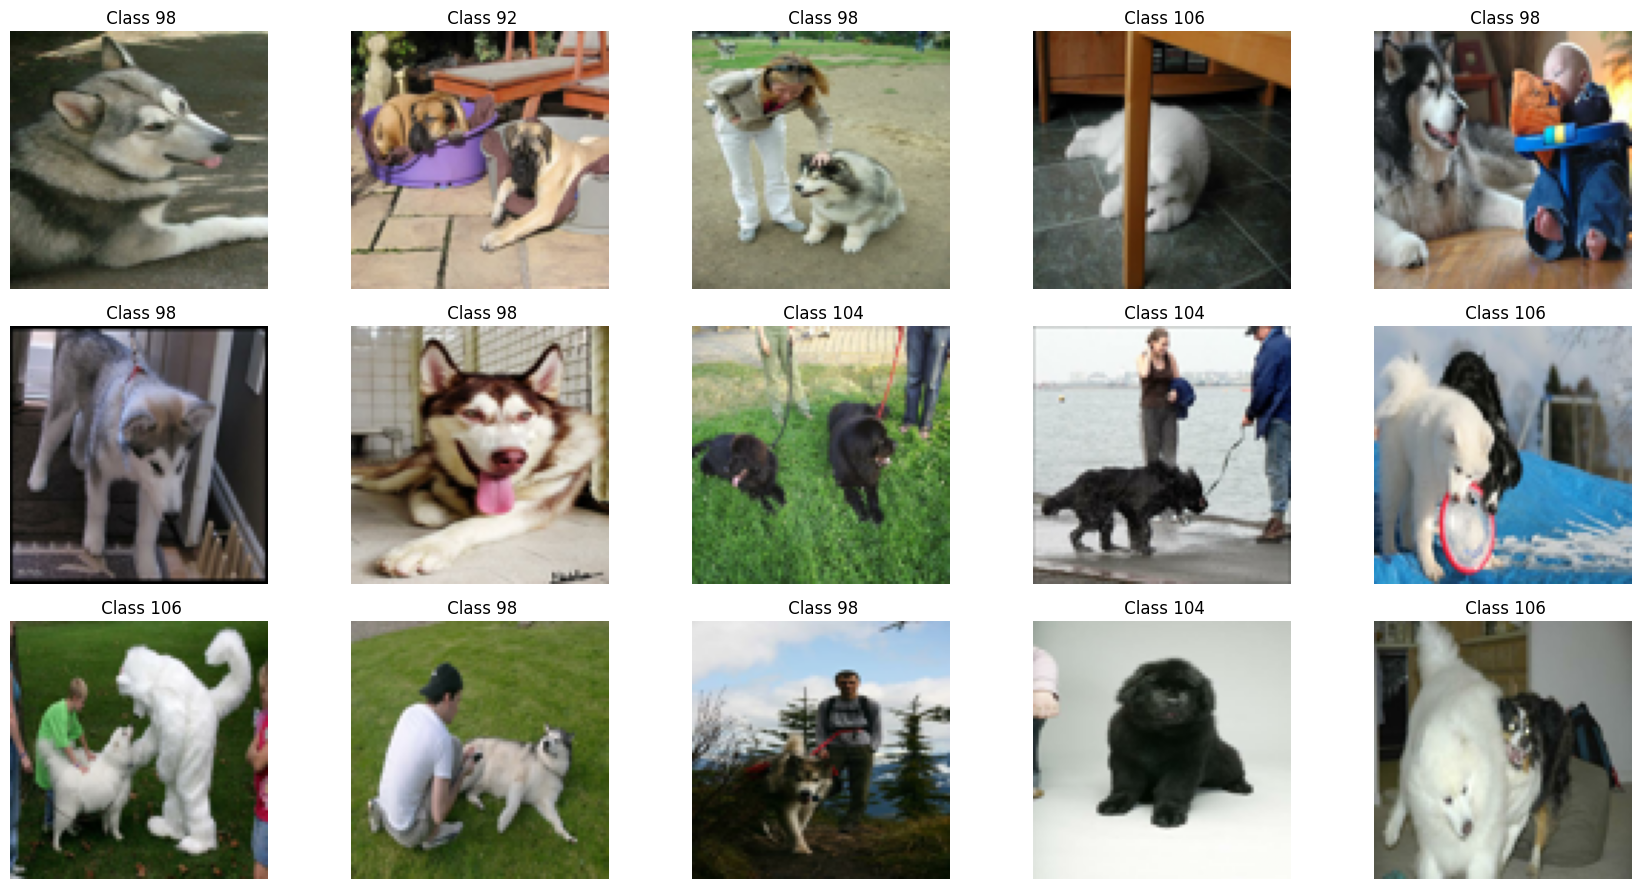

In [ ]:
import random
reverse_label_map = {v: k for k, v in label_map.items()}

def plot_random_sample(images, labels, class_names):
    n = 15
    indices = random.sample(range(len(images)), n)
    imgs = [images[i] for i in indices]
    img_labels = [labels[i] for i in indices]
    num_row = 3
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))

    for i in range(num_row * num_col):
        img = imgs[i]
        label = img_labels[i]
        class_index = np.argmax(label)
        class_name = class_names[class_index]
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)
        ax.set_title(f" {class_name}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

class_names = [f'Class {reverse_label_map[i]}' for i in range(4)]
plot_random_sample(test_images, test_labels, class_names)

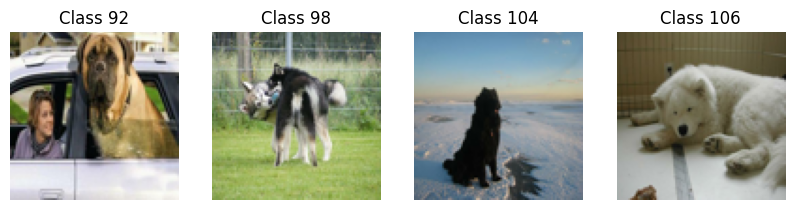

In [ ]:
# Визуализация по одному изображению из каждого класса
def visualize_samples(images, labels, valid_labels):
    plt.figure(figsize=(10, 10))
    for i, label in enumerate(valid_labels):
        for image, lbl in zip(images, labels):
            if np.argmax(lbl) == i:
                plt.subplot(1, 4, i + 1)
                plt.imshow(image, vmin=0, vmax=1)
                plt.title(f"Class {label}")
                plt.axis("off")
                break
    plt.show()

visualize_samples(train_images, train_labels, [92, 98, 104, 106])

**Задание 3**   
Построила нейронные сети RNN и трансформер для задачи многоклассовой классификации изображений (архитектуры и требования к сетям указаны в индивидуальном задании), используя функции потерь, указанные в индивидуальном задании. Обучала нейронные сети с использованием валидационной выборки.


Требования к архитектуре сети RNN:

  - Последовательный API с методом add() при создании

  - Функция потерь: категориальная кросс-энтропия

  - Слой LSTM с 64 нейронами

  - Использование слоев dropout

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

rnn_model = Sequential()
rnn_model.add(Reshape((90 * 90, 3), input_shape=(90, 90, 3)))
rnn_model.add(LSTM(64, return_sequences=True))
rnn_model.add(Dropout(0.1))
rnn_model.add(LSTM(64))
rnn_model.add(Dropout(0.1))
rnn_model.add(Dense(4, activation='softmax'))

# Компиляция модели
rnn_model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])


In [ ]:
rnn_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 8100, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 8100, 64)            │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 8100, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,692 (198.02 KB)

 Trainable params: 50,692 (198.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_rnn = rnn_model.fit(
    train_images, train_labels, validation_data=(validation_images, validation_labels),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],verbose=1
    )

print(f'Количество эпох обучения RNN: {len(history_rnn.history["loss"])}')

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.2391 - loss: 1.4229 - val_accuracy: 0.4362 - val_loss: 1.3316
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.3575 - loss: 1.3718 - val_accuracy: 0.2215 - val_loss: 1.3893
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.3149 - loss: 1.3451 - val_accuracy: 0.3893 - val_loss: 1.3262
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3535 - loss: 1.3276 - val_accuracy: 0.3356 - val_loss: 1.3268
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.3376 - loss: 1.2982 - val_accuracy: 0.4765 - val_loss: 1.2238
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.3698 - loss: 1.2761 - val_accuracy: 0.4430 - val_loss: 1.2278
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.3688 - loss: 1.2700 - val_accuracy: 0.4631 - val_loss: 1.1812
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.3966 - loss: 1.2226 - val_accuracy: 0.4161 - 

Как мы видим, accuracy растет, а потери в целом уменьшаются

In [ ]:
# Оценка результатов обучения
loss_reduction = (history_rnn.history['loss'][0] - history_rnn.history['loss'][-1]) / history_rnn.history['loss'][0] * 100
print(f"Потери снизились на {loss_reduction:.2f}%.")

train_loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']

if val_loss[-1] < train_loss[-1]:
    print("Модель недообучилась.")
elif val_loss[-1] > train_loss[-1] and (val_loss[-1] - train_loss[-1]) / val_loss[-1] > 0.1:
    print("Модель переобучилась")
else:
    print("Модель обучилась.")

Потери снизились на 19.72%.
Модель обучилась.


Требования к архитектуре сети трансформер:

  - Функция потерь: разреженная категориальная кросс-энтропия

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Перевели метки из one-hot encoding в целые числа для использования функции потерь SparseCategoricalCrossentropy()
train_labels_int = np.argmax(train_labels, axis=1)
test_labels_int = np.argmax(test_labels, axis=1)
validation_labels_int = np.argmax(validation_labels, axis=1)

# Преобразование изображений в последовательности
def convert_images_to_sequences(images):
    return images.reshape((images.shape[0], -1, images.shape[3]))

train_sequences = convert_images_to_sequences(train_images)
test_sequences = convert_images_to_sequences(test_images)
validation_sequences = convert_images_to_sequences(validation_images)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Dense(embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def resize_image(image, size=(28, 28)):
    return tf.image.resize(image, size)

train_images_resized = np.array([resize_image(img).numpy() for img in train_images])
test_images_resized = np.array([resize_image(img).numpy() for img in test_images])
validation_images_resized = np.array([resize_image(img).numpy() for img in validation_images])

train_sequences = convert_images_to_sequences(train_images_resized)
test_sequences = convert_images_to_sequences(test_images_resized)
validation_sequences = convert_images_to_sequences(validation_images_resized)

maxlen = train_sequences.shape[1]
embed_dim = 32
num_heads = 2
ff_dim = 16

# Построение модели трансформера
inputs = layers.Input(shape=(maxlen, train_sequences.shape[2]))
embedding_layer = TokenAndPositionEmbedding(maxlen, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation="softmax")(x)

In [ ]:
model_transformer = keras.Model(inputs=inputs, outputs=outputs)

model_transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
# Обучение модели трансформера
history_transformer = model_transformer.fit(
    train_sequences, train_labels_int,
    epochs=50,
    batch_size=32,
    validation_data=(validation_sequences, validation_labels_int)
)
print(f'Количество эпох обучения Transformer: {len(history_transformer.history["loss"])}')

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 676ms/step - accuracy: 0.2556 - loss: 1.4031 - val_accuracy: 0.2752 - val_loss: 1.4013
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 655ms/step - accuracy: 0.2637 - loss: 1.3894 - val_accuracy: 0.2416 - val_loss: 1.3973
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 654ms/step - accuracy: 0.2374 - loss: 1.3996 - val_accuracy: 0.2550 - val_loss: 1.3918
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 655ms/step - accuracy: 0.2493 - loss: 1.3901 - val_accuracy: 0.2483 - val_loss: 1.3835
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 655ms/step - accuracy: 0.2839 - loss: 1.3843 - val_accuracy: 0.2953 - val_loss: 1.3799
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 649ms/step - accuracy: 0.2411 - loss: 1.3862 - val_accuracy: 0.3758 - val_loss: 1.3727
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 658ms/step - accuracy: 0.3198 - loss: 1.3766 - val_accuracy: 0.3490 - val_loss: 1.3668
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 652ms/step - accuracy: 0.3170 - loss: 1.3714 - val_accuracy: 0.

Как мы видим, accuracy хорошо растет, а потери в целом +- стабильно уменьшаются

**Задание 4**  
Вычислите и выведите в отчете матрицы ошибок нейронных сетей (tf.math.confusion_matrix) для обучающей и тестовой выборок.

Матрица ошибок отображает количество прогнозов каждого класса по вертикали и фактических классов по горизонтали, что позволяет легко определить, какие классы модель классифицирует правильно, а какие ошибочно.
Счет классов идет с 0 по строкам и столбцам.

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Предсказания для обучающей и тестовой выборок
rnn_train_predictions = rnn_model.predict(train_images)
rnn_test_predictions = rnn_model.predict(test_images)

# Преобразование предсказаний в метки
rnn_train_pred_labels = np.argmax(rnn_train_predictions, axis=1)
rnn_test_pred_labels = np.argmax(rnn_test_predictions, axis=1)
train_true_labels = np.argmax(train_labels, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

rnn_train_conf_matrix = tf.math.confusion_matrix(train_true_labels, rnn_train_pred_labels)
rnn_test_conf_matrix = tf.math.confusion_matrix(test_true_labels, rnn_test_pred_labels)

In [ ]:
print("RNN матрица ошибок - Training Data")
print(rnn_train_conf_matrix)

print("\nRNN матрица ошибок - Testing Data")
print(rnn_test_conf_matrix)


RNN матрица ошибок - Training Data
tf.Tensor(
[[28  9 21 42]
 [14 15 12 59]
 [11  6 65 18]
 [ 5 10  8 77]], shape=(4, 4), dtype=int32)

RNN матрица ошибок - Testing Data
tf.Tensor(
[[11  1 13 12]
 [ 9  4  3 26]
 [ 4  3 39  5]
 [ 5  9  2 52]], shape=(4, 4), dtype=int32)


Видим, что на тренировочных данных модель хорошо справляется с классификацией Класса 3 (77 правильно классифицировано). Модель также хорошо справляется с классификацией Класса 3 (52 правильно классифицировано) на тестовых данных.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Предсказания для обучающей и тестовой выборок
transformer_train_predictions = model_transformer.predict(train_sequences)
transformer_test_predictions = model_transformer.predict(test_sequences)

# Преобразование предсказаний в метки
transformer_train_pred_labels = np.argmax(transformer_train_predictions, axis=1)
transformer_test_pred_labels = np.argmax(transformer_test_predictions, axis=1)

# Преобразование меток в целые числа
train_true_labels = np.argmax(train_labels, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

transformer_train_conf_matrix = confusion_matrix(train_true_labels, transformer_train_pred_labels)
transformer_test_conf_matrix = confusion_matrix(test_true_labels, transformer_test_pred_labels)


In [ ]:
print("Transformer матрица ошибок - Training Data")
print(transformer_train_conf_matrix)

print("\Transformer матрица ошибок - Testing Data")
print(transformer_test_conf_matrix)

Transformer матрица ошибок - Training Data
[[71 11 13  5]
 [ 8 62 16 14]
 [ 3  6 91  0]
 [ 3 28  1 68]]
\Transformer матрица ошибок - Testing Data
[[18  6 11  2]
 [ 2 19 10 11]
 [ 0  5 46  0]
 [ 6 14  3 45]]


Видим, что на тренировочных данных модель показывает высокую точность для Класса 2 (91 правильно классифицировано). И на тестовых данных модель хорошо справляется с классификацией Класса 2 (46 правильно классифицировано).



**Задание 5**  
Визуализируйте кривые обучения построенных моделей для показателей потерь на обучающей и валидационной выборках на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительные потери (потери, деленные на начальные потери на первой эпохе).

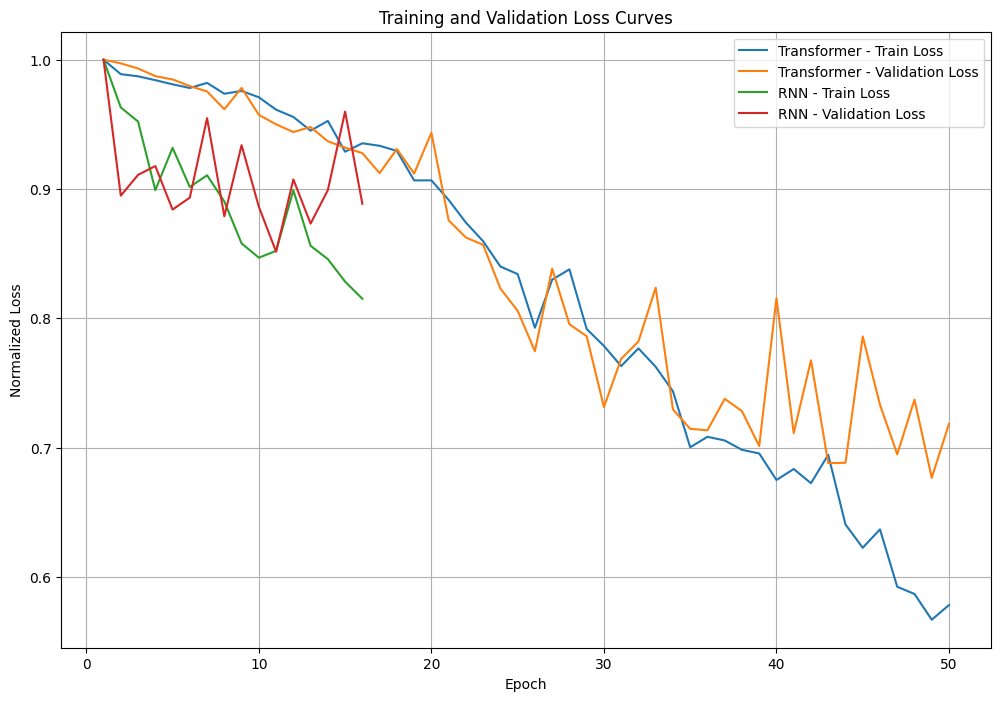

In [ ]:
# Извлечение потерь на обучающей и валидационной выборках
rnn_train_loss = history_rnn.history['loss']
rnn_val_loss = history_rnn.history['val_loss']

transformer_train_loss = history_transformer.history['loss']
transformer_val_loss = history_transformer.history['val_loss']

# Нормализация потерь относительно начальных потерь первой эпохи для RNN
rnn_train_loss_normalized = [loss / rnn_train_loss[0] for loss in rnn_train_loss]
rnn_val_loss_normalized = [loss / rnn_val_loss[0] for loss in rnn_val_loss]

# Нормализация потерь относительно начальных потерь первой эпохи для transformer
transformer_train_loss_normalized = [loss / transformer_train_loss[0] for loss in transformer_train_loss]
transformer_val_loss_normalized = [loss / transformer_val_loss[0] for loss in transformer_val_loss]

plt.figure(figsize=(12, 8))

plt.plot(range(1, len(transformer_train_loss_normalized) + 1), transformer_train_loss_normalized, label='Transformer - Train Loss')
plt.plot(range(1, len(transformer_val_loss_normalized) + 1), transformer_val_loss_normalized, label='Transformer - Validation Loss')

plt.plot(range(1, len(rnn_train_loss_normalized) + 1), rnn_train_loss_normalized, label='RNN - Train Loss')
plt.plot(range(1, len(rnn_val_loss_normalized) + 1), rnn_val_loss_normalized, label='RNN - Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

**Задание 6**  
Оцените качество многоклассовой классификации нейронными сетями на тестовой выборке при помощи показателя качества, указанного в индивидуальном задании, и выведите название нейронной сети с лучшим качеством.

Показатель качества многоклассовой классификации:

  - средняя полнота классов, где полнота (recall) класса равна доле правильных предсказаний для всех точек, принадлежащих этому классу.

In [ ]:
from sklearn.metrics import recall_score

test_labels_single = np.argmax(test_labels, axis=1)

# Вычисление recall для модели RNN
rnn_recall = recall_score(test_labels_single, rnn_test_predictions.argmax(axis=1), average=None)
rnn_average_recall = np.mean(rnn_recall)

# Вычисление recall для модели Transformer
transformer_recall = recall_score(test_labels_single, transformer_test_predictions.argmax(axis=1), average=None)
transformer_average_recall = np.mean(transformer_recall)

# Определение названия модели с лучшим качеством по средней полноте
best_model = "RNN" if rnn_average_recall > transformer_average_recall else "Transformer"

print("Средняя полнота классов (recall) на тестовой выборке:")
print("RNN:", rnn_average_recall)
print("Transformer:", transformer_average_recall)
print("Лучшая модель по средней полноте:", best_model)


Средняя полнота классов (recall) на тестовой выборке:
RNN: 0.5048262548262548
Transformer: 0.6256482322658793
Лучшая модель по средней полноте: Transformer
